Для начала подключим все необходимые библиотеки.

In [1]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import functional as F
from tqdm import trange
import numpy as np
import copy

torch.manual_seed(42)
EPOCHS = 10000
ATTACK_EPOCHS = 10000

In [2]:
def show_digit(digit):
    plt.imshow(digit.reshape(8, 8), 'gray')

Разобьём MNIST dataset на тренировочную и тестовую части.

In [3]:
digits = load_digits()
X, y = digits.data, digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test = torch.tensor(X_train, dtype=torch.float), torch.tensor(X_test, dtype=torch.float)
y_train, y_test = torch.LongTensor(y_train), torch.LongTensor(y_test)

Зададим архитектуру нейронной сети, loss-функцию и оптимизатор.

In [4]:
model = nn.Sequential(
    nn.Linear(64, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer = Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

Обучим нейросеть на тренировочных данных.

In [5]:
for epoch in trange(EPOCHS):
    out = model(X_train)
    loss = loss_function(out, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:30<00:00, 326.57it/s]


Проверим ошибки классификации на тренировочных и на тестовых данных.

In [6]:
with torch.no_grad():
    train_acc = np.sum(y_train.numpy() == model(X_train).numpy().argmax(axis=1)) / y_train.shape[0]
    test_acc = np.sum(y_test.numpy() == model(X_test).numpy().argmax(axis=1)) / y_test.shape[0]
print(f'train acc: {train_acc}')
print(f'test acc: {test_acc}')

train acc: 1.0
test acc: 0.975


Похоже на то, что не переобучились. Посмотрим, на каких тестовых примерах ошибается наша модель.

In [7]:
with torch.no_grad():
    pred = model(X_test).numpy().argmax(axis=1)
    ind_wrong = y_test.numpy() != pred
    pred = pred[ind_wrong]
    X_wrong, y_wrong = X_test.numpy()[ind_wrong], y_test.numpy()[ind_wrong]
print(f'Wrong predicted: {int(np.sum(ind_wrong))}/{X_test.shape[0]}')

Wrong predicted: 9/360


True label: 9, Predicted: 3


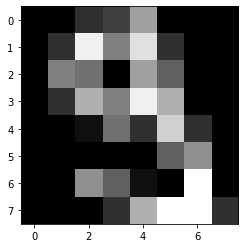

In [8]:
show_digit(X_wrong[0])
print(f'True label: {y_wrong[0]}, Predicted: {pred[0]}')

True label: 7, Predicted: 9


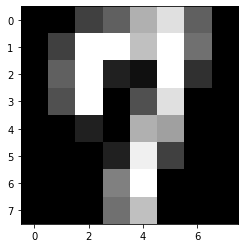

In [9]:
show_digit(X_wrong[1])
print(f'True label: {y_wrong[1]}, Predicted: {pred[1]}')

True label: 3, Predicted: 5


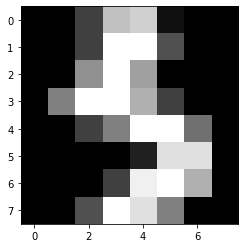

In [10]:
show_digit(X_wrong[2])
print(f'True label: {y_wrong[2]}, Predicted: {pred[2]}')

Примеры, предсказанные обученной моделью неправильно, действительно сложно однозначно отнести к одному из классов. Попробуем провести целевую атаку на нашу обученную сеть. В качестве примера возьмём цифру 6 и попробуем немного поменять её так, чтобы наша модель стала предсказывать вместо неё 0.

Target: 6


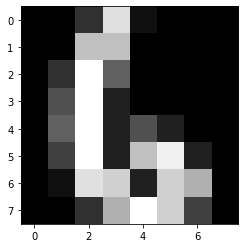

In [11]:
example = copy.deepcopy(X_train[0])
example_target = y_train[0]
show_digit(example)
print(f'Target: {example_target}')

In [12]:
x = torch.unsqueeze(example, 0)  # меняем размерность нашего примера, чтобы его можно было передать модели
x_target = copy.deepcopy(x)  # хотим, чтобы полученный нами пример в итоге не сильно отличался от исходного
x.requires_grad = True  # хотим считать градиент loss-функции по нашему примеру
target = torch.LongTensor([0])  # хотим, чтобы обученная нейросеть классифицировала пример как "0"

Атакуем

In [13]:
for epoch in trange(ATTACK_EPOCHS):
    out = model(x)
    loss = F.cross_entropy(out, target)
    loss.backward()
    x.data -= 0.001 * (x.grad + 50*(x.data - x_target.data))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2312.41it/s]


Получили следующий пример, он действительно не сильно отличается от исходной цифры 6 визуально.

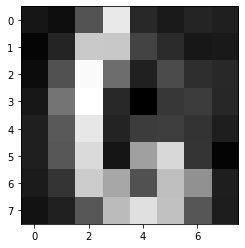

In [14]:
show_digit(x.detach().numpy())

Однако нейронная сеть уверенно классифицирует пример, как цифру "0".

In [15]:
with torch.no_grad():
    print(int(model(x).argmax(axis=1)))

0


In [16]:
with torch.no_grad():
    print(F.softmax(model(x), dim=-1))

tensor([[9.9872e-01, 1.4266e-16, 6.7912e-15, 1.8995e-22, 1.9545e-07, 8.0079e-08,
         1.2771e-03, 8.4375e-18, 6.8338e-07, 1.6961e-17]])
